In [1]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt
from copy import copy

import time

## Estas funcion calcula los valores de forma exacta
def FHExacto(params):
    qubits = params["sites"]*2
    hopping = params["hopping"]
    potential = params["potential"]
    fermi_sentence = 0.0
    fermi_hopping = 0.0
    fermi_potential = 0.0
    

    if params["sites"] == 1:
        fermi_sentence +=  potential*FermiC(0)*FermiA(0)*FermiC(1)*FermiA(1)
    else:
        for i in range(params["sites"]-1):
            if hopping != 0.0:
                fermi_hopping +=  FermiC(2*i)*FermiA(2*i +2) + FermiC(2*i +2)*FermiA(2*i)
                fermi_hopping +=  FermiC(2*i+1)*FermiA(2*i +3) + FermiC(2*i +3)*FermiA(2*i +1)  
            
        for i in range(params["sites"]):
            if potential != 0.0:
                fermi_potential += FermiC(2*i)*FermiA(2*i)*FermiC(2*i +1)*FermiA(2*i +1)

        if params["pattern"] == "close" and params["sites"] != 2:
            qsite = 2*(params["sites"]-1)
            fermi_hopping +=  FermiC(0)*FermiA(qsite) + FermiC(qsite)*FermiA(0)
            fermi_hopping +=  FermiC(1)*FermiA(qsite+1) + FermiC(qsite+1)*FermiA(1) 

    fermi_sentence = -hopping*fermi_hopping + potential*fermi_potential
    h = qml.jordan_wigner( fermi_sentence )

    val, vec = np.linalg.eigh(h.sparse_matrix().toarray())
    return np.sort( val )

In [2]:
params1 = {
    "sites": 4,  #Numero de sitios 2,4,6
    "hopping": 0.5, #Este hay que dejarlo fijo
    "potential": 0, #Este hay que variarlo
    "pattern": "close" #Este se puede variar <close> o <open>
}

a = FHExacto(params1)

### Memoria

In [10]:
from pympler import asizeof

def MemoriaFH(params):
    qubits = params["sites"]*2
    hopping = params["hopping"]
    potential = params["potential"]
    fermi_sentence = 0.0
    fermi_hopping = 0.0
    fermi_potential = 0.0
    

    if params["sites"] == 1:
        fermi_sentence +=  potential*FermiC(0)*FermiA(0)*FermiC(1)*FermiA(1)
    else:
        for i in range(params["sites"]-1):
            if hopping != 0.0:
                fermi_hopping +=  FermiC(2*i)*FermiA(2*i +2) + FermiC(2*i +2)*FermiA(2*i)
                fermi_hopping +=  FermiC(2*i+1)*FermiA(2*i +3) + FermiC(2*i +3)*FermiA(2*i +1)  
            
        for i in range(params["sites"]):
            if potential != 0.0:
                fermi_potential += FermiC(2*i)*FermiA(2*i)*FermiC(2*i +1)*FermiA(2*i +1)

        if params["pattern"] == "close" and params["sites"] != 2:
            qsite = 2*(params["sites"]-1)
            fermi_hopping +=  FermiC(0)*FermiA(qsite) + FermiC(qsite)*FermiA(0)
            fermi_hopping +=  FermiC(1)*FermiA(qsite+1) + FermiC(qsite+1)*FermiA(1) 

    fermi_sentence = -hopping*fermi_hopping + potential*fermi_potential

    h = qml.jordan_wigner( fermi_sentence)
    return asizeof.asizeof(h)

In [14]:
for i in range(1, 8):
    params1 = {
    "sites": i+1,  #Numero de sitios 2,4,6
    "hopping": 1, #Este hay que dejarlo fijo
    "potential": 2.0, #Este hay que variarlo
    "pattern": "open" #Este se puede variar <close> o <open>
    }

    print( MemoriaFH(params1) )

55208
100576
144696
189912
234032
278152
322272


In [15]:
for i in range(1, 8):
    params1 = {
    "sites": i+1,  #Numero de sitios 2,4,6
    "hopping": 1, #Este hay que dejarlo fijo
    "potential": 2.0, #Este hay que variarlo
    "pattern": "open" #Este se puede variar <close> o <open>
    }
    hubbard_chain1 = vqe_fermihubbard(params1)
    hubbard_chain1.set_group_characteristics()

    print( asizeof.asizeof(hubbard_chain1) )

5792
7224
9752
17416
42968
142056
536704


## Fermi-Hubbard

In [2]:
params1 = {
    "sites": 3,  #Numero de sitios 2,4,6
    "hopping": 0.5, #Este hay que dejarlo fijo
    "potential": 0.0, #Este hay que variarlo
    "pattern": "open" #Este se puede variar <close> o <open>
}

hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()


### Barrido hopping

In [13]:
hopping = np.linspace(-1.2,1.2,20)
exacto = []
for t in hopping:
    params1 = {
        "sites": 4,  #Numero de sitios 2,4,6
        "hopping": t, #Este hay que dejarlo fijo
        "potential": 0.0, #Este hay que variarlo
        "pattern": "open" #Este se puede variar <close> o <open>
    }

    ee = FHExacto(params1)
    exacto.append(ee[0])

In [10]:
hopping = np.linspace(-1.2, 1.2, 20)
valores_kup = []
for t in hopping:
    print(t)
    params1 = {
    "sites": 4, 
    "hopping": t,
    "potential": 0.0, 
    "pattern": "open"
    }

    hubbard_chain1 = vqe_fermihubbard(params1)
    hubbard_chain1.set_group_characteristics()

    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": params1["sites"],
        "qubits": hubbard_chain1.qubits,
    }

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 50,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    valores_kup.append(energy1[-1])


-1.2
-1.5770037314709973
-2.9226721306634165
-4.048540494795246
-4.79323924780875
-5.155406178304217
-5.294031765666757
-5.341948879419174
-5.358161313776281
-5.363673934776985
-5.365564375301846
-5.366216767465101
-5.366442790161983
-5.366521273335032
-5.366548556994791
-5.366558041609523
-5.366561328214464
-5.366562448034539
-5.366562798297521
-1.0736842105263158
-1.2776088368181546
-2.395404899888767
-3.369220148456465
-4.084237890753601
-4.492294335394261
-4.6781361849858065
-4.753359204061798
-4.782744237676268
-4.794201423998633
-4.798701007674213
-4.800481416557195
-4.801189797902985
-4.801472666725784
-4.8015858743419475
-4.801631241306426
-4.8016494338129725
-4.801656729355308
-4.801659652090972
-4.8016608190867185
-4.801661280647036
-0.9473684210526315
-1.0270207953369832
-1.9352231722118187
-2.7464660975112567
-3.392177870490419
-3.8154574997834843
-4.042830113643734
-4.150123789010276
-4.19818690107981
-4.219492895110245
-4.22897788706544
-4.233232607755969
-4.2351544962512

In [11]:
hopping = np.linspace(-1.2,1.2,20)
valores_ucc = []
for t in hopping:
    print(t)
    params1 = {
    "sites": 4, 
    "hopping": t,
    "potential": 0.0, 
    "pattern": "open"
    }

    hubbard_chain1 = vqe_fermihubbard(params1)
    hubbard_chain1.set_group_characteristics()

    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": params1["sites"],
        "qubits": hubbard_chain1.qubits,
    }

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 50,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    valores_ucc.append(energy1[-1])

-1.2
-0.8614729804880209
-1.6466282883724115
-2.3664445528147424
-2.9886208885565893
-3.4878288170728093
-3.866307459120043
-4.147062693761708
-4.3584012804956735
-4.523529673282596
-4.657515953656615
-4.768873403088772
-4.8622888577072185
-4.940673927446355
-5.006249022768362
-5.060962544480008
-5.106583675002156
-5.144684665576847
-5.176613880511115
-5.203491233311118
-5.226225833780943
-5.24554614926105
-5.262033483359451
-5.276152996476982
-5.288279699933645
-5.298718953829532
-5.307722060984282
-5.31549791950156
-5.322221695298158
-5.3280413199870384
-5.333082428942115
-5.337452183678433
-5.341242289174767
-5.344531420063682
-5.3473872028018095
-5.34986785605274
-5.352023561765025
-5.353897619708071
-5.355527425008821
-5.356945299171032
-5.358179198664879
-5.35925332051313
-5.360188620783868
-5.36100325917564
-5.361712980709977
-5.362331443792969
-5.362870502463213
-5.363340449447723
-5.363750225648156
-5.364107600839392
-5.36441932965592
-1.0736842105263158
-0.7057301436320426
-1

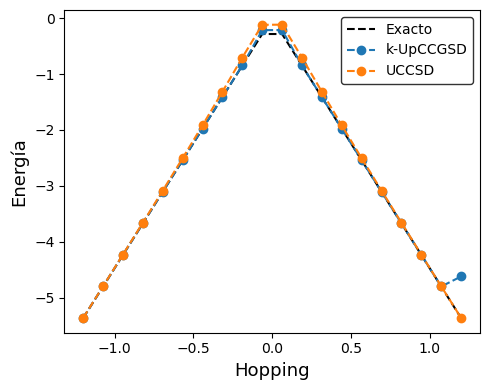

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5,4),)
ax.set_xlabel("Hopping", fontsize=13)
ax.set_ylabel("Energía", fontsize=13)

ax.plot(hopping, exacto, color="black", ls="dashed", label="Exacto")
ax.plot(hopping, valores_kup, marker='o', ls="dashed", label="k-UpCCGSD")
ax.plot(hopping, valores_ucc, marker='o', ls="dashed", label="UCCSD")

ax.legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

### Barrido theta

In [26]:
params1 = {
    "sites": 3,  #Numero de sitios 2,4,6
    "hopping": 1.5, #Este hay que dejarlo fijo
    "potential": 0.0, #Este hay que variarlo
    "pattern": "open" #Este se puede variar <close> o <open>
}

hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()

ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "interface": "autograd",
    "electrons": params1["sites"],
    "qubits": hubbard_chain1.qubits,
}

ansazt = upccgsd_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

In [28]:
theta = np.linspace(0.2, 0.5, 11)
valores = []
for t in theta:
    print(t)
    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", t]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    print( len(energy1) )
    valores.append(energy1)

0.2
17
0.23
15
0.26
13
0.29000000000000004
12
0.32
12
0.35
19
0.38
8
0.41000000000000003
41
0.44
41
0.47000000000000003
41
0.5
41


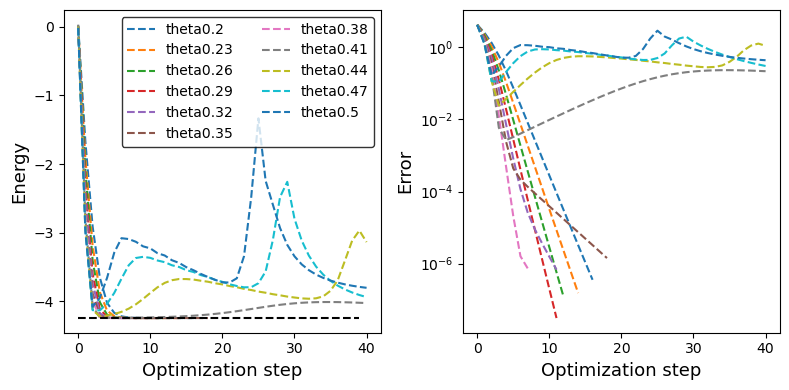

In [29]:
ee = FHExacto(params1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="theta"+str(np.round(theta[i],3)))
    ax[1].plot([j for j in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")

ax[0].plot([j for j in range( 40 ) ], [ee[0] for j in range(40)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=2)
fig.tight_layout()
plt.show()

### Open model

In [185]:
params1 = {
    "sites": 4,  #Numero de sitios 2,4,6
    "hopping": 0.75, #Este hay que dejarlo fijo
    "potential": 0, #Este hay que variarlo
    "pattern": "close" #Este se puede variar <close> o <open>
}

hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()

In [186]:
valores_kup = []
for k in range(1):
    print(k+1)
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": params1["sites"],
        "qubits": hubbard_chain1.qubits,
        "pattern": "chain"
    }

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    valores_kup.append(energy1)

1


In [187]:
valores_ucc = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": params1["sites"],
        "qubits": hubbard_chain1.qubits,
        "pattern": "chain"
    }


    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    valores_ucc.append(energy1)

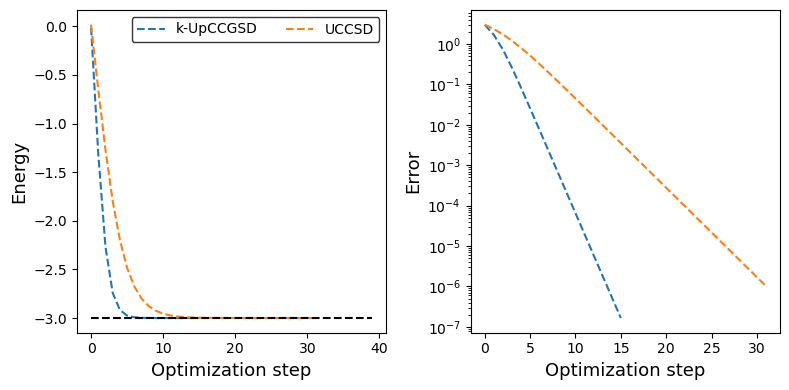

In [189]:
ee = FHExacto(params1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

for i, val in enumerate(valores_kup):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k-UpCCGSD")
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed", label="k-UpCCGSD")

for i, val in enumerate(valores_ucc):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="UCCSD")
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed", label="UCCSD")

ax[0].plot([j for j in range( 40 ) ], [ee[0] for j in range(40)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=2)
fig.tight_layout()
plt.show()

### Tiempo

In [2]:
params1 = {
    "sites": 4,  
    "hopping": 1.0, 
    "potential": 0.0, 
    "pattern": "open" 
}
hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()
print( len(hubbard_chain1.hamiltonian_object) )
ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "interface": "autograd",
    "electrons": params1["sites"],
    "qubits": hubbard_chain1.qubits,
    "pattern": "chain"
}
ansazt = upccgsd_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

minimizate_params = {
    "type": "SLSQP",
    "maxiter": 60,
    "tol": 1e-6,
    "number":  a*b,
    "theta":["generic", 0.30]}

hubbard_chain1.node = ansazt.node

tiempo = []
for i in range(10):
    optimizer = gradiend_optimizer(minimizate_params)
    print(i+1)
    inicio = time.time()
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    final = time.time()

    tiempo.append(final-inicio)
    print(tiempo)

4
1
-0.007519437963529482
[3.014816999435425]
2
-0.006589619372479788
[3.014816999435425, 3.014254093170166]
3


KeyboardInterrupt: 

In [11]:
tiempo

[85.39467406272888,
 82.17762589454651,
 86.65287971496582,
 86.1475031375885,
 82.48712205886841,
 85.81289601325989,
 85.81194496154785,
 82.43488383293152,
 85.88253712654114,
 85.86024403572083]

In [39]:
def FHExacto_tiempo(params):
    qubits = params["sites"]*2
    hopping = params["hopping"]
    potential = params["potential"]
    fermi_sentence = 0.0
    fermi_hopping = 0.0
    fermi_potential = 0.0
    

    if params["sites"] == 1:
        fermi_sentence +=  potential*FermiC(0)*FermiA(0)*FermiC(1)*FermiA(1)
    else:
        for i in range(params["sites"]-1):
            if hopping != 0.0:
                fermi_hopping +=  FermiC(2*i)*FermiA(2*i +2) + FermiC(2*i +2)*FermiA(2*i)
                fermi_hopping +=  FermiC(2*i+1)*FermiA(2*i +3) + FermiC(2*i +3)*FermiA(2*i +1)  
            
        for i in range(params["sites"]):
            if potential != 0.0:
                fermi_potential += FermiC(2*i)*FermiA(2*i)*FermiC(2*i +1)*FermiA(2*i +1)

        if params["pattern"] == "close" and params["sites"] != 2:
            qsite = 2*(params["sites"]-1)
            fermi_hopping +=  FermiC(0)*FermiA(qsite) + FermiC(qsite)*FermiA(0)
            fermi_hopping +=  FermiC(1)*FermiA(qsite+1) + FermiC(qsite+1)*FermiA(1) 

    fermi_sentence = -hopping*fermi_hopping + potential*fermi_potential

    h = qml.jordan_wigner( fermi_sentence)
    h = h.sparse_matrix().toarray()
    inicio = time.time()
    val, vec = np.linalg.eigh(h)
    final = time.time()
    return final-inicio

In [49]:
params1 = {
    "sites": 7,  
    "hopping": 1.5, 
    "potential": 0.0, 
    "pattern": "open" 
}

for i in range(10):
    print( FHExacto_tiempo(params1) )

0.0014338493347167969
0.000988006591796875
0.0009741783142089844
0.0006136894226074219
0.0006000995635986328
0.0006928443908691406
0.0005300045013427734
0.00048804283142089844
0.0004589557647705078
0.0005047321319580078
